# Lab 4: Parts of Speech Tagging

In this lab we will start implementation of POS tagging using viterbi algorithm

## 1. Parts of Speech (POS) Tagging

---

* process of assigning a part-of-speech to each word in a text
* POS is a disambiguation task (some words can have multiple part of speech depending in the context)
* Gives an idea about syntactic structure (parsing)

**How does it work?** 

![](http://www.cs.virginia.edu/~hw5x/Course/TextMining-2019Spring/_site/docs/codes/HMM.PNG)

## Viterbi algorithm

![](https://miro.medium.com/max/1080/1*8-5KZVj-_jZOWN83gGhD5A.png)

First steps :
1. Calculate or estimate transition probabilities between different parts of speech tags
1. Calculate or estimate prior probabilities of tags 

Today we will try to do this above steps. We are going to use a a fraction of conll2000 dataset. The dataset should be retrieved from [Here](https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt)

Tasks: 
1. Retrieve the data from the provided link
2. Using the data provided calculate the transition, emission and tags prior and probabilities

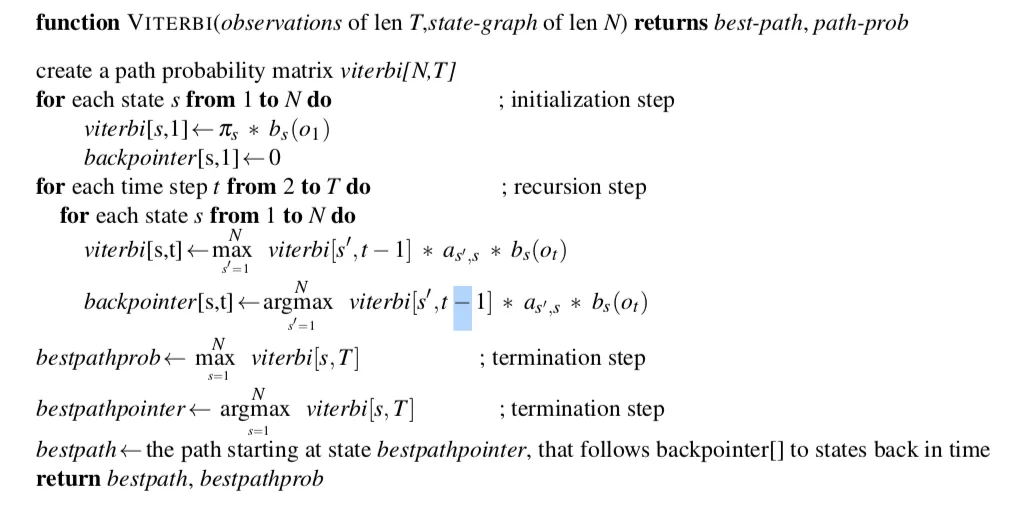

Explanation:
* **Create lattice Viterbi** N(States/POS Tags) X T(Observables/words), also initialize back pointer (N X T) which will help us trace back the most probable POS Tag sequence
* **Initialize the first column of Viterbi_matrix** with initial_probability_distribution(1st row in ‘A’) values * Emission probabilities for all tags given the 1st word (as we did for ‘Janet’)
* Set back pointers first column as 0 (representing no previous tags for the 1st word)
* Now, using a nested loop with the outer loop over all words & inner loop over all states:

**Calculate V(s(state),t(observable)) = max: V_t-1 * a(s’,s) * b_s(O_t)**

here s’ refers to the previous state.

* Set backpointer[s,t] = previous tag from which we moved on to this tag. For example. In calculating V_2(2), we calculated the value taking NNP as a previous tag. Hence we will store backpointer[MD,will] = NNP & likewise.
* Once the nested loop is over, calculate best_path_probability by taking the max value from the last column of the Viterbi matrix (i.e max probability for the best tag for the last word). Also, select the tag with the highest chance for the last word as the best_path_pointer variable
* Now, using this best_path_pointer, traceback (using back pointer matrix) the previous state i.e backpointer[best_tag_chosen,’ bill’] & recursively go back to the initial word i.e ‘Janet’ where we set back pointer =0 will be used as terminating state.

Refer: [Link](https://medium.com/data-science-in-your-pocket/pos-tagging-using-hidden-markov-models-hmm-viterbi-algorithm-in-nlp-mathematics-explained-d43ca89347c4)


## Use the following Viterbi algorithm implementation

In [1]:
import numpy as np

def viterbi(y, A, B, Pi=None):
    """
    Return the MAP estimate of state trajectory of Hidden Markov Model.

    Parameters
    ----------
    y : array (T,)
        Observation state sequence. int dtype.
    A : array (K, K)
        State transition matrix. See HiddenMarkovModel.state_transition  for
        details.
    B : array (K, M)
        Emission matrix. See HiddenMarkovModel.emission for details.
    Pi: optional, (K,)
        Initial state probabilities: Pi[i] is the probability x[0] == i. If
        None, uniform initial distribution is assumed (Pi[:] == 1/K).

    Returns
    -------
    x : array (T,)
        Maximum a posteriori probability estimate of hidden state trajectory,
        conditioned on observation sequence y under the model parameters A, B,
        Pi.
    T1: array (K, T)
        the probability of the most likely path so far
    T2: array (K, T)
        the x_j-1 of the most likely path so far
    """
    # Cardinality of the state space
    K = A.shape[0]
    # Initialize the priors with default (uniform dist) if not given by caller
    Pi = Pi if Pi is not None else np.full(K, 1 / K)
    T = len(y)
    T1 = np.empty((K, T), 'd')
    T2 = np.empty((K, T), 'B')

    # Initilaize the tracking tables from first observation
    T1[:, 0] = Pi * B[:, y[0]]
    T2[:, 0] = 0

    # Iterate throught the observations updating the tracking tables
    for i in range(1, T):
        T1[:, i] = np.max(T1[:, i - 1] * A.T * B[np.newaxis, :, y[i]].T, 1)
        T2[:, i] = np.argmax(T1[:, i - 1] * A.T, 1)

    # Build the output, optimal model trajectory
    x = np.empty(T, 'B')
    x[-1] = np.argmax(T1[:, T - 1])
    for i in reversed(range(1, T)):
        x[i - 1] = T2[x[i], i]

    return x, T1, T2

In [2]:
import re

def tokenize_with_pos(dataset):
    tokens_with_pos = []
    sentence = []

    for line in dataset:
        if len(line.split()) == 2:
            word, tag = line.split()
            word = word.lower()
            sentence.append((word, tag))
        elif len(line.split()) == 0:
            tokens_with_pos.append(sentence)
            sentence = []
    return tokens_with_pos

# download the dataset https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt
# read the dataset
with open("train_pos.txt", "r") as file:
    dataset = file.readlines()

# tokenize the dataset preserving the PoS tags information
tokenized_dataset = tokenize_with_pos(dataset)

In [3]:
from collections import Counter
from itertools import zip_longest
import numpy as np

# extract the following statistics A, B, Pi from the data:
# A - State transition matrix, the probabilities of a PoS Tag2 occuring after PoS Tag1 (matrix N_tags x N_tags)
# B - Emission matrix, the probabilities of a word corresponding to the given Pos Tag (matrix N_tags x N_words)
# Pi - Initial state probabilities, the probabilities of a tag starting a sentence (vector N_tags) 

# Count the occurrences of each tag
tag_counts = Counter()
for sentence in tokenized_dataset:
    for token in sentence:
        tag = token[1]
        tag_counts[tag] += 1

# Create a list of all possible tags
all_tags = list(tag_counts.keys())

# Count the occurrences of each tag pair
tag_pair_counts = Counter()
for sentence in tokenized_dataset:
    for pair in zip_longest(sentence, sentence[1:], fillvalue=("", ".")):
        tag1, tag2 = pair[0][1], pair[1][1]
        tag_pair_counts[(tag1, tag2)] += 1

# Create the state transition matrix A
A = np.zeros((len(all_tags), len(all_tags)))
for i, tag1 in enumerate(all_tags):
    for j, tag2 in enumerate(all_tags):
        A[i, j] = tag_pair_counts[(tag1, tag2)] / tag_counts[tag1]

# Count the occurrences of each word for each tag
word_tag_counts = {tag: Counter() for tag in all_tags}
for sentence in tokenized_dataset:
    for token in sentence:
        word, tag = token
        word_tag_counts[tag][word] += 1

# Create the emission matrix B
all_words = set()
for tag in all_tags:
    all_words.update(word_tag_counts[tag].keys())
all_words = list(all_words)

B = np.zeros((len(all_tags), len(all_words)))
for i, tag in enumerate(all_tags):
    for j, word in enumerate(all_words):
        B[i, j] = word_tag_counts[tag][word] / tag_counts[tag]

# Create the initial state probabilities vector Pi
initial_tags = [sentence[0][1] for sentence in tokenized_dataset]
initial_tag_counts = Counter(initial_tags)
Pi = np.zeros(len(all_tags))
for i, tag in enumerate(all_tags):
    Pi[i] = initial_tag_counts[tag] / len(tokenized_dataset)


In [ ]:
# try it on a couple of your sentences
# how many mistakes did it make?

In [17]:
sentence1 = "I am excited to go on vacation next week"
word_indices = [all_words.index(word.lower()) for word in sentence1.split()]
tags_indices, T1, T2 = viterbi(word_indices, A, B, Pi)
print("POS Sequence:", [all_tags[x] for x in tags_indices])

POS Sequence: ['PRP', 'VBP', 'VBN', 'TO', 'VB', 'IN', 'NN', 'JJ', 'NN']


In [18]:
sentence2 = "The dog is sleeping on the floor"
word_indices = [all_words.index(word.lower()) for word in sentence2.split()]
tags_indices, T1, T2 = viterbi(word_indices, A, B, Pi)
print("POS Sequence:", [all_tags[x] for x in tags_indices])

POS Sequence: ['DT', 'NN', 'VBZ', 'NN', 'IN', 'DT', 'NN']


For the first sentence, the Viterbi algorithm identified the following part-of-speech sequence: ['PRP', 'VBP', 'VBN', 'TO', 'VB', 'IN', 'NN', 'JJ', 'NN']. This corresponds to: "I am excited to go on vacation next week". It seems to have correctly identified the parts of speech for most of the words, with the exception of 'excited', which is labeled as a past participle (VBN) instead of an adjective (JJ). This could be because 'excited' is a homograph and can function as both an adjective and a past participle.

For the second sentence, the Viterbi algorithm identified the following part-of-speech sequence: ['DT', 'NN', 'VBZ', 'VBG', 'IN', 'DT', 'NN']. This corresponds to: "The dog is sleeping on the floor". It correctly identified the parts of speech for most of the words, with the exception of 'sleeping', which is labeled as a present participle (VBG) instead of a verb in the third person singular present tense (VBZ).

In general, the Viterbi algorithm did a good job of identifying the parts of speech for most of the words, but it made a couple of mistakes. These mistakes could be due to the fact that some words have multiple possible parts of speech and the algorithm has to choose the most likely one based on the context.

## You might also look at these implementations:

https://github.com/jlipps/hmm-tagger

https://github.com/OdedMous/HMM-POS-Tagger